In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

C:\Users\Sana\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Sana\AppData\Local\Temp\ipykernel_4484\2045549709.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [45]:
data = pd.read_csv('data/final_dataset.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

for col in data.columns[data.isna().any()].tolist():
    data[col].fillna(0, inplace=True)

data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

data_test = data[(data['data_source'] == 'Rheinbay et al 2020') | (data['data_source'] == 'Dr.Nod 2023')]
len_test_data = len(data_test)
data_test = pd.concat([data_test, data[data['data_source'] == 'COSMIC'].sample(n=len_test_data, random_state=42)])   # get an equal amount of negative data
data = data.drop(data_test.index, inplace=False).reset_index(drop=True, inplace=False)
data_test.reset_index(drop=True, inplace=True)

C:\Users\Sana\AppData\Local\Temp\ipykernel_4484\4277214832.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(0, inplace=True)


In [46]:
feat_df = pd.read_csv('data/feature_selected_after_corr_feateng.csv')

COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]
COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x in feat_df.columns]
for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

numeric_cols = data[COLUMNS_TRAINING].select_dtypes(include=['float64', 'int64', 'int32']).nunique()

COLUMNS_TO_SHOW = numeric_cols[numeric_cols > 2].index  # pick numeric columns that are not one-hot encoded
    
COLUMN_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TO_SHOW]

In [22]:
feat_df.columns

Index(['SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG',
       'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant',
       'NMD_transcript_variant', 'downstream_gene_variant', 'intron_variant',
       'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
       'splice_polypyrimidine_tract_variant', 'upstream_gene_variant',
       'MODIFIER', 'CTCF_binding_site', 'enhancer', 'nonsense_mediated_decay',
       'processed_pseudogene', 'processed_transcript', 'promoter',
       'protein_coding', 'retained_intron', 'unprocessed_pseudogene', 'DNA',
       'LINE', 'LTR', 'Simple_repeat', 'known_driver_gene_100kb_downstream',
       'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
       'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream',
       'known_driver_gene_2kb_upstream', 'splice_donor_region_variant',
       'splice_donor_5th_base_variant', 'missense_variant',
       'synonymous_variant', 's

# Boxplot

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 30))

bplot1 = ax1.boxplot(data[COLUMNS_TO_SHOW].iloc[:, 0:11],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMN_LABELS[0:11])

bplot2 = ax2.boxplot(data[COLUMNS_TO_SHOW].iloc[:, 11:22],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMN_LABELS[11:22])

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('Normalized Observed values', fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)

fig.suptitle('Boxplot Normalised Dataset', fontsize=30)
fig.tight_layout(pad=2)
plt.show()

# Histogram

In [ ]:
COLUMNS_TRAINING_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TRAINING]
num = 8
col = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
for i in range(0, num):
    for j in range(0, num):
        colour_dict = {0: 'pink', 1: 'lightblue'}
        axes[i][j].hist([data.loc[data['driver'] == x, COLUMNS_TRAINING[col]] for x in colour_dict.keys()],
                color=[colour_dict[x] for x in colour_dict.keys()],
                edgecolor='black',
                stacked=True)
        axes[i][j].set_xlabel(COLUMNS_TRAINING_LABELS[col], fontsize=20, wrap=True)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].tick_params(axis='x', labelsize=15)

        col = col + 1
        if col >= len(COLUMNS_TRAINING):
            break

fig.suptitle('Histogram of Normalised Dataset', fontsize=30)
fig.legend(colour_dict, labels=['non-driver', 'driver'], loc='upper left', ncol = 2, fontsize=20)
fig.tight_layout(pad=2)

# Correlation Matrix

In [52]:
COLUMNS_TRAINING = ['ada_score', 'rf_score',
                    'ENSP', 'UNIPARC', 'GO', 'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
                    '3_prime_UTR_variant', '5_prime_UTR_variant',
                    'NMD_transcript_variant', 
                    'downstream_gene_variant',
                    'intergenic_variant', 'intron_variant',
                    'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
                    'regulatory_region_variant',
                    'splice_donor_variant', 'splice_polypyrimidine_tract_variant',
                    'upstream_gene_variant', 'MODIFIER', 'MotifFeature',
                    'RegulatoryFeature', 'Transcript', 'CTCF_binding_site',
                    'enhancer', 'nonsense_mediated_decay',
                    'processed_pseudogene', 'processed_transcript', 'promoter',
                    'protein_coding', 'retained_intron',
                    'unprocessed_pseudogene',
                    'CTCF_interactions', 'POLR2A_interactions', 'CTCF_loops', 'POLR2A_loops',
                    'DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat',
                    'known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
                    'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',
                    'splice_acceptor_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant',
                    'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'frameshift_variant',
                    'TF_loss', 'TF_gain', 'TF_loss_diff', 'TF_gain_diff',
                    'known_lncrna', 'known_lncrna_100kb_downstream', 'known_lncrna_100kb_upstream', 'known_lncrna_10kb_downstream',
                    'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream'
                  ]

TO_REMOVE = []

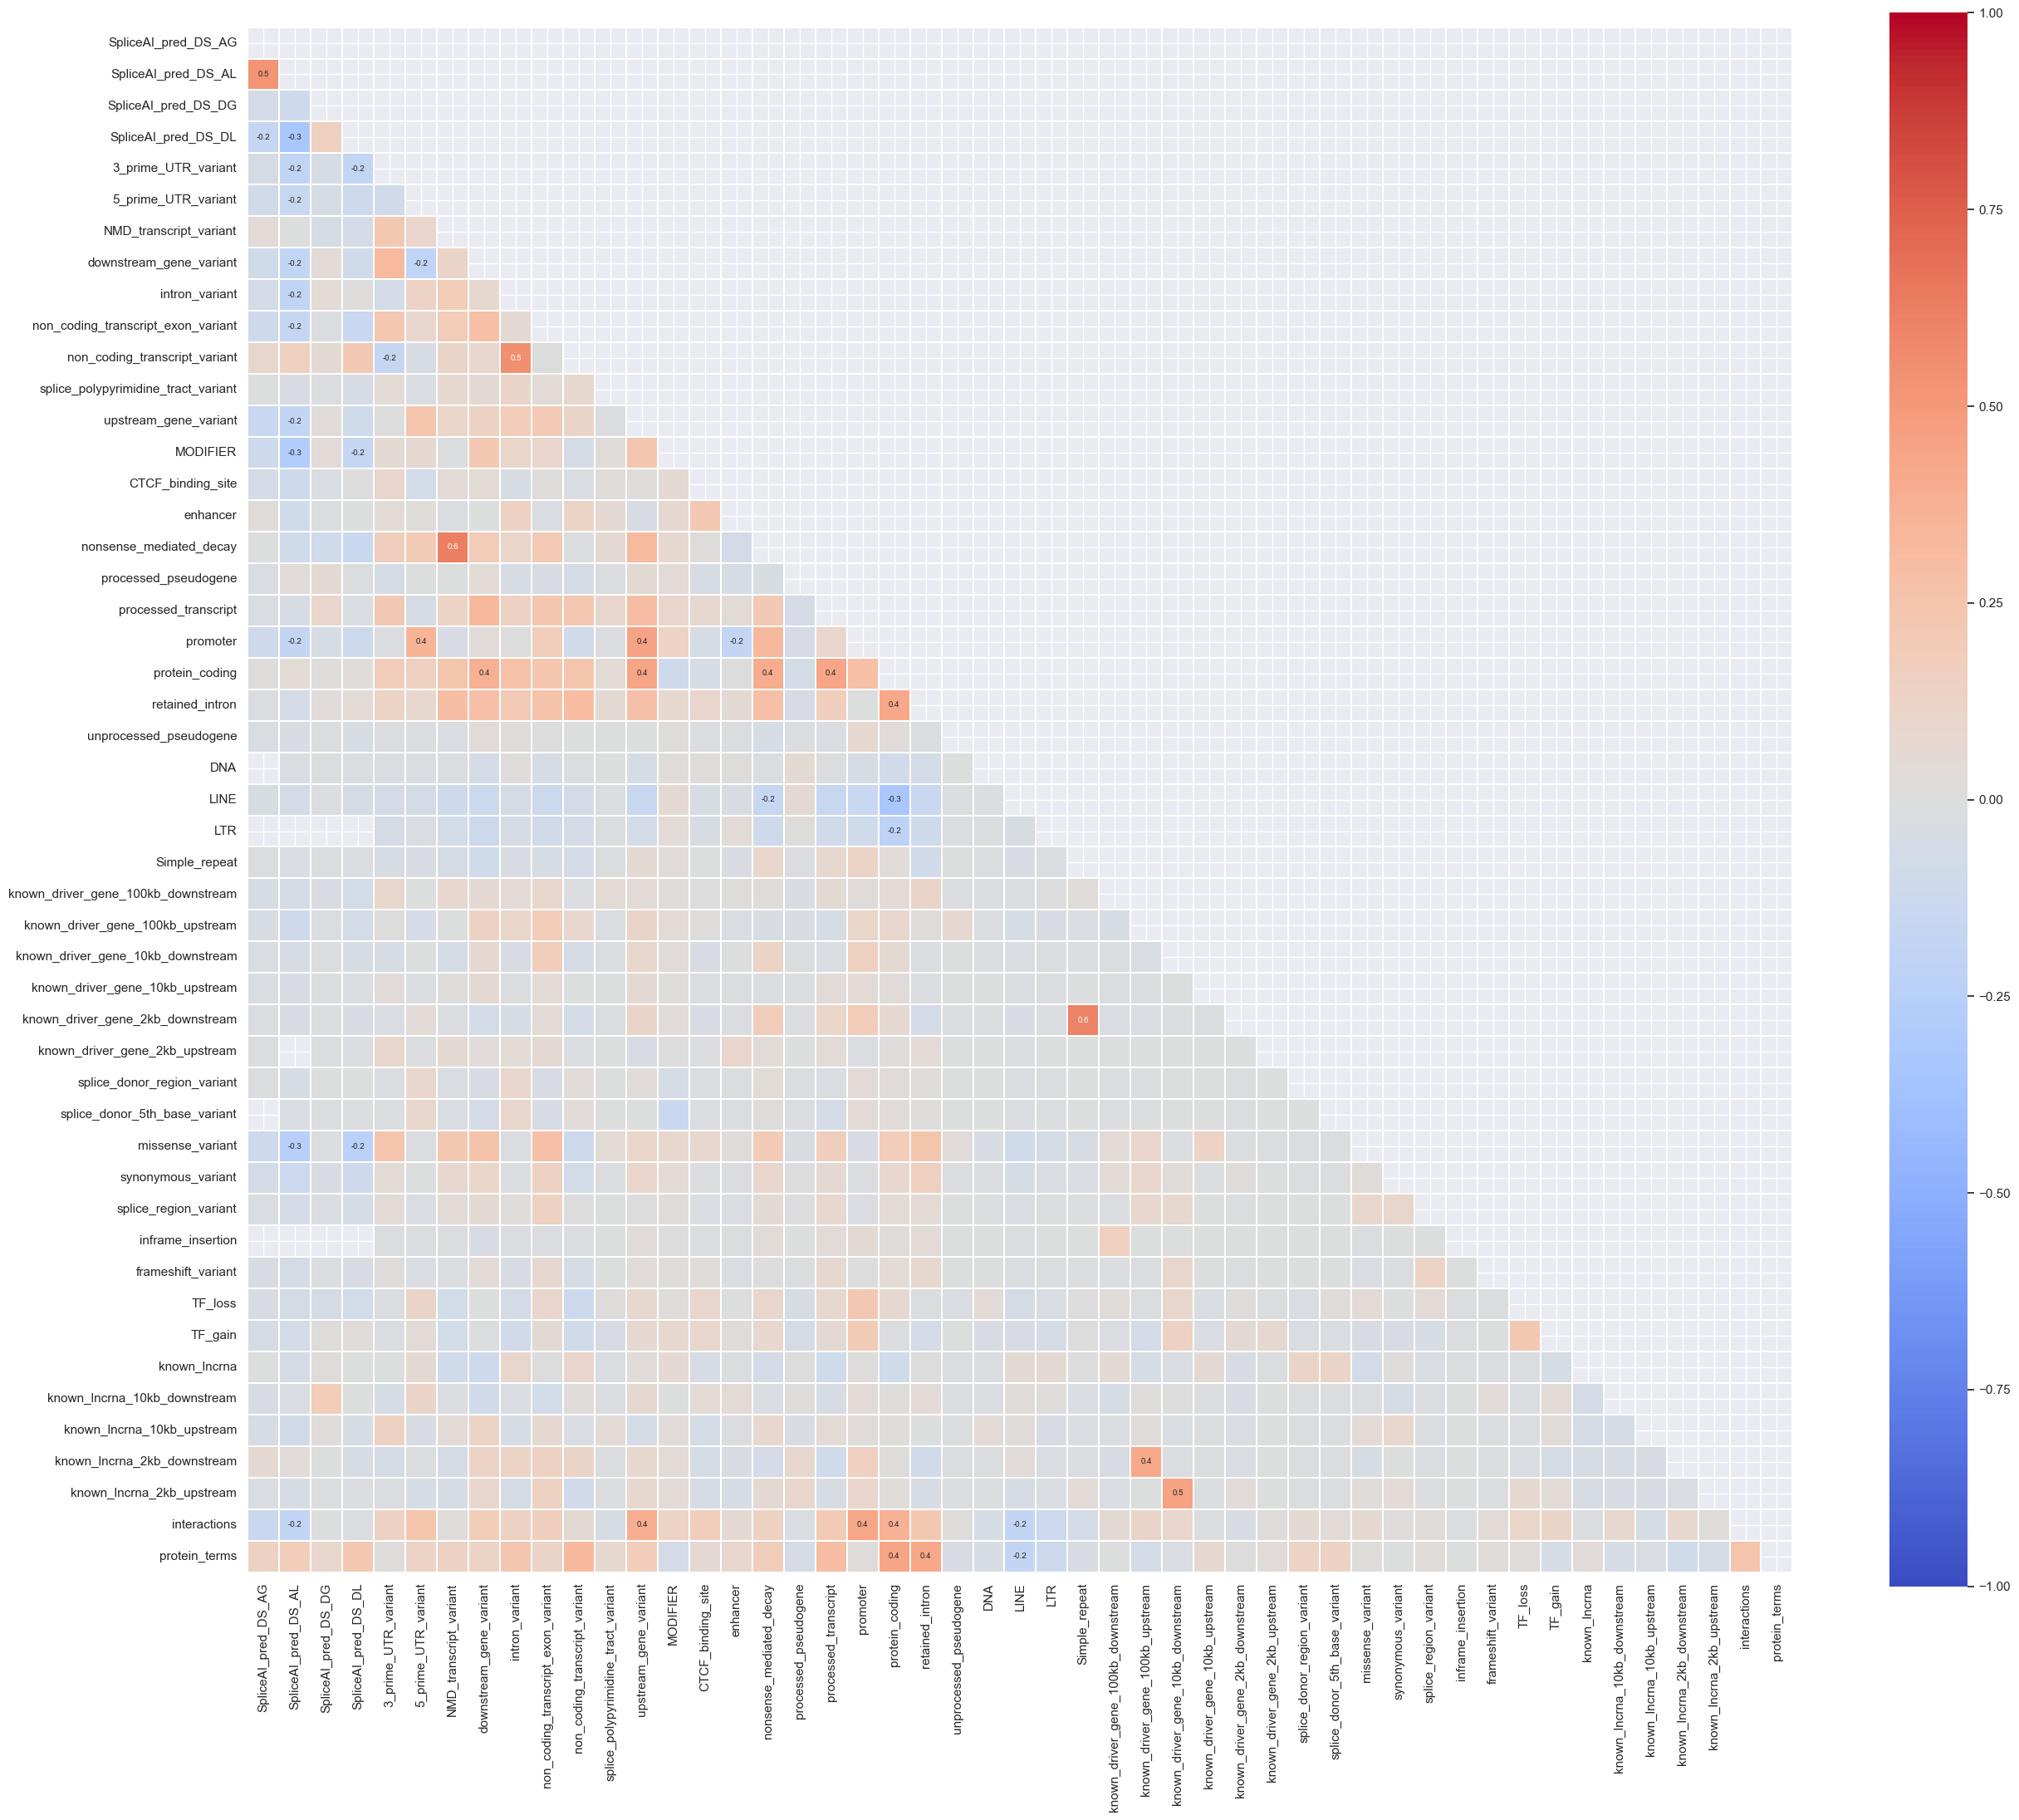

In [35]:
COLUMNS_WITH_DRIVER = COLUMNS_TRAINING
# COLUMNS_WITH_DRIVER.append('driver')
corr_matrix = data[COLUMNS_TRAINING].corr()
matrix = np.triu(corr_matrix)
sns.set(font_scale=0.6)
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(30,30)})
# sns.set(rc=)

ax= sns.heatmap(corr_matrix, mask=matrix, vmin=-1, vmax=+1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":7}, cmap='coolwarm')

sns.set()
for t in ax.texts:
    if float(t.get_text())>=0.4 or float(t.get_text())<=-0.2:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

# Feature Engineering

In [47]:
data['SpliceAI_pred_DS_AG'] = data['SpliceAI_pred_DS_AG'].divide(data['SpliceAI_pred_DP_AG']).replace(np.inf, 0)
data['SpliceAI_pred_DS_AL'] = data['SpliceAI_pred_DS_AL'].divide(data['SpliceAI_pred_DP_AL']).replace(np.inf, 0)
data['SpliceAI_pred_DS_DG'] = data['SpliceAI_pred_DS_DG'].divide(data['SpliceAI_pred_DP_DG']).replace(np.inf, 0)
data['SpliceAI_pred_DS_DL'] = data['SpliceAI_pred_DS_DL'].divide(data['SpliceAI_pred_DP_DL']).replace(np.inf, 0)

data['interactions'] = data['CTCF_interactions'] + data['POLR2A_interactions']
# data['loops'] = data['CTCF_loops'] + data['POLR2A_loops']

data['TF_loss'] = data['TF_loss_add'] + data['TF_loss_diff_add']
data['TF_gain'] = data['TF_gain_add'] + data['TF_gain_diff_add']

data['protein_terms'] = data['ENSP'] + data['UNIPARC'] + data['GO']

to_remove = ['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL',
             'CTCF_interactions', 'POLR2A_interactions', 'CTCF_loops', 'POLR2A_loops', 'rf_score',
             'TF_binding_site_agg', 'TF_loss_add', 'TF_gain_add', 'TF_loss_diff', 'TF_gain_diff', 'TF_loss_diff_add', 'TF_gain_diff_add',
             'Transcript', 'regulatory_region_variant', 'intergenic_variant', 'ENSP', 'UNIPARC', 'GO',
             'MotifFeature', 'splice_donor_variant', 'splice_acceptor_variant']

COLUMNS_TRAINING = [e for e in COLUMNS_TRAINING if e not in to_remove]
COLUMNS_TRAINING.extend(['interactions', 'protein_terms'])

In [95]:
to_remove = ['DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat']
data['repeat_elements'] = data['DNA'] + data['LINE'] + data['SINE'] + data['Simple_repeat']
COLUMNS_TRAINING = [e for e in COLUMNS_TRAINING if e not in to_remove]
COLUMNS_TRAINING.extend(['repeat_elements'])

In [90]:
COLUMNS_TRAINING = ['SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant', 'downstream_gene_variant', 'intron_variant',
'non_coding_transcript_exon_variant', 'non_coding_transcript_variant', 'splice_polypyrimidine_tract_variant', 'upstream_gene_variant',
'MODIFIER', 'CTCF_binding_site', 'enhancer', 'processed_pseudogene', 'processed_transcript', 'protein_coding', 'retained_intron', 'unprocessed_pseudogene',
'DNA', 'LINE', 'LTR', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream', 'known_driver_gene_10kb_upstream',
'known_driver_gene_2kb_upstream', 'splice_donor_region_variant', 'splice_donor_5th_base_variant', 'missense_variant', 'synonymous_variant', 'splice_region_variant',
'inframe_insertion', 'frameshift_variant', 'TF_loss', 'TF_gain', 'known_lncrna', 'known_lncrna_10kb_downstream', 'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream',
'interactions', 'protein_terms']

In [106]:
COLUMNS_TRAINING

['SpliceAI_pred_DS_AG',
 'SpliceAI_pred_DS_AL',
 'SpliceAI_pred_DS_DG',
 'SpliceAI_pred_DS_DL',
 '3_prime_UTR_variant',
 '5_prime_UTR_variant',
 'downstream_gene_variant',
 'intron_variant',
 'non_coding_transcript_exon_variant',
 'non_coding_transcript_variant',
 'splice_polypyrimidine_tract_variant',
 'upstream_gene_variant',
 'MODIFIER',
 'CTCF_binding_site',
 'enhancer',
 'processed_pseudogene',
 'processed_transcript',
 'protein_coding',
 'retained_intron',
 'unprocessed_pseudogene',
 'known_driver_gene_100kb_downstream',
 'known_driver_gene_100kb_upstream',
 'known_driver_gene_10kb_downstream',
 'known_driver_gene_10kb_upstream',
 'known_driver_gene_2kb_upstream',
 'splice_donor_region_variant',
 'splice_donor_5th_base_variant',
 'missense_variant',
 'synonymous_variant',
 'splice_region_variant',
 'inframe_insertion',
 'frameshift_variant',
 'TF_loss',
 'TF_gain',
 'known_lncrna',
 'known_lncrna_10kb_downstream',
 'known_lncrna_10kb_upstream',
 'known_lncrna_2kb_downstream',
 'k

In [98]:
# s = corr_matrix.abs().unstack()
# so = s.sort_values(kind="quicksort")
# so
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

print("Top Absolute Correlations")
corr_top = get_top_abs_correlations(data[COLUMNS_TRAINING], 5)
corr_top

Top Absolute Correlations


SpliceAI_pred_DS_AG                SpliceAI_pred_DS_AL              5.756696e-01
intron_variant                     non_coding_transcript_variant    5.494094e-01
known_driver_gene_10kb_downstream  known_lncrna_2kb_upstream        4.551179e-01
processed_transcript               protein_coding                   4.405897e-01
upstream_gene_variant              protein_coding                   4.379560e-01
                                                                        ...     
known_driver_gene_2kb_upstream     inframe_insertion                9.407338e-04
SpliceAI_pred_DS_DL                known_lncrna_10kb_downstream     7.225743e-04
upstream_gene_variant              splice_region_variant            3.686393e-04
retained_intron                    known_lncrna                     1.926716e-04
processed_pseudogene               synonymous_variant               3.540032e-18
Length: 861, dtype: float64

In [99]:
print("> 0.5: ", len(corr_top[corr_top > 0.5]))
print("> 0.6: ", len(corr_top[corr_top > 0.6]))
print("> 0.8: ", len(corr_top[corr_top > 0.8]))

> 0.5:  2
> 0.6:  0
> 0.8:  0


In [102]:
high_corr = set()
for i in corr_top[corr_top > 0.8].index:
    high_corr.add(i[0])
    high_corr.add(i[1])
high_corr

set()

In [103]:
corr_driver = data[COLUMNS_TRAINING].corrwith(data['driver']).abs()
corr_driver[corr_driver>0.5]

Series([], dtype: float64)

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data[COLUMNS_TRAINING] = data[COLUMNS_TRAINING].fillna(0)
def compute_vif(considered_features):
    
    X = data[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# compute vif 
vif = compute_vif(COLUMNS_TRAINING).sort_values('VIF', ascending=False)

C:\Users\Sana\AppData\Local\Temp\ipykernel_4484\4249666627.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


In [105]:
vif[vif['VIF'] > 10]

,Variable,VIF


In [67]:
# to_remove = ['CTCF_interactions',  'CTCF_loops',  'ENSP',  'POLR2A_interactions',  'POLR2A_loops',  'RegulatoryFeature',  'SpliceAI_pred_DS_AG',
#  'SpliceAI_pred_DS_AL',  'SpliceAI_pred_DS_DL',  'TF_gain',  'TF_gain_add', 'TF_gain_diff',  'TF_gain_diff_add',
#  'TF_loss',  'TF_loss_add',  'TF_loss_diff',  'TF_loss_diff_add',  'Transcript',  'UNIPARC',  'intergenic_variant',  'protein_coding',
#  'regulatory_region_variant',  'splice_acceptor_variant',  'splice_donor_variant']

to_remove = ['known_lncrna_100kb_downstream',  'known_lncrna_100kb_upstream',  'RegulatoryFeature', 'ada_score', 'known_driver_gene']

# to_remove.extend(['ada_score', 'known_driver_gene'])
# to_remove.extend(['RegulatoryFeature', 'TF_loss_add', 'TF_gain_add', 'TF_gain_diff_add', 'TF_loss_diff_add',
# 'TF_gain_diff', 'TF_loss_diff', 'Transcript', 'regulatory_region_variant', 'TF_loss', 'intergenic_variant',
# 'CTCF_loops', 'CTCF_interactions', 'POLR2A_interactions', 'POLR2A_loops', 'UNIPARC', 'ENSP', 'SpliceAI_pred_DS_AL',
# 'MotifFeature', 'ada_score', 'SpliceAI_pred_DS_DL', 'known_lncrna_100kb_downstream', 'splice_donor_variant',
# 'known_lncrna_100kb_upstream', 'splice_acceptor_variant', 'promoter'])
# to_remove
SELECTED_COLUMNS_TRAINING = [e for e in COLUMNS_TRAINING if e not in to_remove]

In [64]:
SELECTED_COLUMNS_TRAINING = ['SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant', 'NMD_transcript_variant', 'downstream_gene_variant', 'intron_variant',
'non_coding_transcript_exon_variant', 'non_coding_transcript_variant', 'splice_polypyrimidine_tract_variant', 'upstream_gene_variant',
'MODIFIER', 'CTCF_binding_site', 'enhancer', 'nonsense_mediated_decay', 'processed_pseudogene', 'processed_transcript', 'promoter', 'protein_coding', 'retained_intron', 'unprocessed_pseudogene',
'DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream', 'known_driver_gene_10kb_upstream',
'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream', 'splice_donor_region_variant', 'splice_donor_5th_base_variant', 'missense_variant', 'synonymous_variant', 'splice_region_variant',
'inframe_insertion', 'frameshift_variant', 'TF_loss', 'TF_gain', 'known_lncrna', 'known_lncrna_10kb_downstream', 'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream',
'interactions', 'protein_terms']

In [ ]:
to_remove = ['NMD_transcript_variant',  'RegulatoryFeature',  'Simple_repeat',  'ada_score',
 'known_driver_gene',  'known_driver_gene_2kb_downstream',
 'known_lncrna_100kb_downstream',  'known_lncrna_100kb_upstream',
 'nonsense_mediated_decay',  'promoter', 'ada_score', 'known_driver_gene','known_lncrna_100kb_downstream',
'known_lncrna_100kb_upstream', 'RegulatoryFeature']

SELECTED_COLUMNS_TRAINING = [e for e in SELECTED_COLUMNS_TRAINING if e not in to_remove]
SELECTED_COLUMNS_TRAINING

In [76]:
to_remove = ['NMD_transcript_variant',  'RegulatoryFeature',  'Simple_repeat',  'ada_score',
 'known_driver_gene',  'known_driver_gene_2kb_downstream',
 'known_lncrna_100kb_downstream',  'known_lncrna_100kb_upstream',
 'nonsense_mediated_decay',  'promoter', 'ada_score', 'known_driver_gene','known_lncrna_100kb_downstream',
'known_lncrna_100kb_upstream', 'RegulatoryFeature']
COLS = ['SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant', 'NMD_transcript_variant', 'downstream_gene_variant', 'intron_variant',
'non_coding_transcript_exon_variant', 'non_coding_transcript_variant', 'splice_polypyrimidine_tract_variant', 'upstream_gene_variant',
'MODIFIER', 'CTCF_binding_site', 'enhancer', 'nonsense_mediated_decay', 'processed_pseudogene', 'processed_transcript', 'promoter', 'protein_coding', 'retained_intron', 'unprocessed_pseudogene',
'DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream', 'known_driver_gene_10kb_upstream',
'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream', 'splice_donor_region_variant', 'splice_donor_5th_base_variant', 'missense_variant', 'synonymous_variant', 'splice_region_variant',
'inframe_insertion', 'frameshift_variant', 'TF_loss', 'TF_gain', 'known_lncrna', 'known_lncrna_10kb_downstream', 'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream',
'interactions', 'protein_terms']
temp1 = [e for e in COLS if e not in to_remove]
len(temp1)

45

In [82]:
temp2 = ['SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant', 'downstream_gene_variant', 'intron_variant',
'non_coding_transcript_exon_variant', 'non_coding_transcript_variant', 'splice_polypyrimidine_tract_variant', 'upstream_gene_variant',
'MODIFIER', 'CTCF_binding_site', 'enhancer', 'processed_pseudogene', 'processed_transcript', 'protein_coding', 'retained_intron', 'unprocessed_pseudogene',
'DNA', 'LINE', 'LTR', 'SINE', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream', 'known_driver_gene_10kb_upstream',
'known_driver_gene_2kb_upstream', 'splice_donor_region_variant', 'splice_donor_5th_base_variant', 'missense_variant', 'synonymous_variant', 'splice_region_variant',
'inframe_insertion', 'frameshift_variant', 'TF_loss', 'TF_gain', 'known_lncrna', 'known_lncrna_10kb_downstream', 'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream',
'interactions', 'protein_terms']

In [86]:
len(temp2)

45

In [5]:
feat_df = pd.read_csv('data/feature_selected_after_corr_feateng.csv')
feat_df.columns

Index(['SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG',
       'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant',
       'NMD_transcript_variant', 'downstream_gene_variant', 'intron_variant',
       'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
       'splice_polypyrimidine_tract_variant', 'upstream_gene_variant',
       'MODIFIER', 'CTCF_binding_site', 'enhancer', 'nonsense_mediated_decay',
       'processed_pseudogene', 'processed_transcript', 'promoter',
       'protein_coding', 'retained_intron', 'unprocessed_pseudogene', 'DNA',
       'LINE', 'LTR', 'Simple_repeat', 'known_driver_gene_100kb_downstream',
       'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
       'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream',
       'known_driver_gene_2kb_upstream', 'splice_donor_region_variant',
       'splice_donor_5th_base_variant', 'missense_variant',
       'synonymous_variant', 's

In [101]:
temp =['NMD_transcript_variant',  'RegulatoryFeature',  'Simple_repeat',  'ada_score',
 'known_driver_gene',  'known_driver_gene_2kb_downstream',
 'known_lncrna_100kb_downstream',  'known_lncrna_100kb_upstream',
 'nonsense_mediated_decay',  'promoter', 'ada_score', 'known_driver_gene','known_lncrna_100kb_downstream',
'known_lncrna_100kb_upstream', 'RegulatoryFeature']

COLUMNS_ORIG = config['COLUMNS_TRAINING']

In [86]:
to_check = ['CTCF_interactions',  'CTCF_loops',  'ENSP',  'POLR2A_interactions',  'POLR2A_loops',  'RegulatoryFeature',  'SpliceAI_pred_DS_AG',
 'SpliceAI_pred_DS_AL',  'SpliceAI_pred_DS_DL',  'TF_gain',  'TF_gain_add', 'TF_gain_diff',  'TF_gain_diff_add',
 'TF_loss',  'TF_loss_add',  'TF_loss_diff',  'TF_loss_diff_add',  'Transcript',  'UNIPARC',  'intergenic_variant',  'protein_coding',
 'regulatory_region_variant',  'splice_acceptor_variant',  'splice_donor_variant', 'ada_score', 'known_driver_gene',
 'TF_gain', 'RegulatoryFeature', 'TF_loss_add', 'TF_gain_add', 'TF_gain_diff_add',
'TF_loss_diff_add', 'TF_gain_diff', 'TF_loss_diff', 'Transcript', 'regulatory_region_variant', 'TF_loss', 'intergenic_variant'
'CTCF_loops', 'CTCF_interactions', 'POLR2A_interactions', 'POLR2A_loops', 'UNIPARC', 'ENSP', 'SpliceAI_pred_DS_AL',
'MotifFeature', 'ada_score', 'SpliceAI_pred_DS_DL', 'known_lncrna_100kb_downstream', 'splice_donor_variant'
'known_lncrna_100kb_upstream', 'splice_acceptor_variant', 'promoter']

In [110]:
set(SELECTED_COLUMNS_TRAINING) - set(temp)
# len(to_check)

{'3_prime_UTR_variant',
 '5_prime_UTR_variant',
 'CTCF_binding_site',
 'DNA',
 'LINE',
 'LTR',
 'MODIFIER',
 'SINE',
 'SpliceAI_pred_DS_AG',
 'SpliceAI_pred_DS_AL',
 'SpliceAI_pred_DS_DG',
 'SpliceAI_pred_DS_DL',
 'TF_gain',
 'TF_loss',
 'downstream_gene_variant',
 'enhancer',
 'frameshift_variant',
 'inframe_insertion',
 'interactions',
 'intron_variant',
 'known_driver_gene_100kb_downstream',
 'known_driver_gene_100kb_upstream',
 'known_driver_gene_10kb_downstream',
 'known_driver_gene_10kb_upstream',
 'known_driver_gene_2kb_upstream',
 'known_lncrna',
 'known_lncrna_10kb_downstream',
 'known_lncrna_10kb_upstream',
 'known_lncrna_2kb_downstream',
 'known_lncrna_2kb_upstream',
 'missense_variant',
 'non_coding_transcript_exon_variant',
 'non_coding_transcript_variant',
 'processed_pseudogene',
 'processed_transcript',
 'protein_coding',
 'protein_terms',
 'retained_intron',
 'splice_donor_5th_base_variant',
 'splice_donor_region_variant',
 'splice_polypyrimidine_tract_variant',
 'spli

In [15]:
vif.to_csv('vif.csv', index=False)

In [54]:
data.fillna(0, inplace=True)